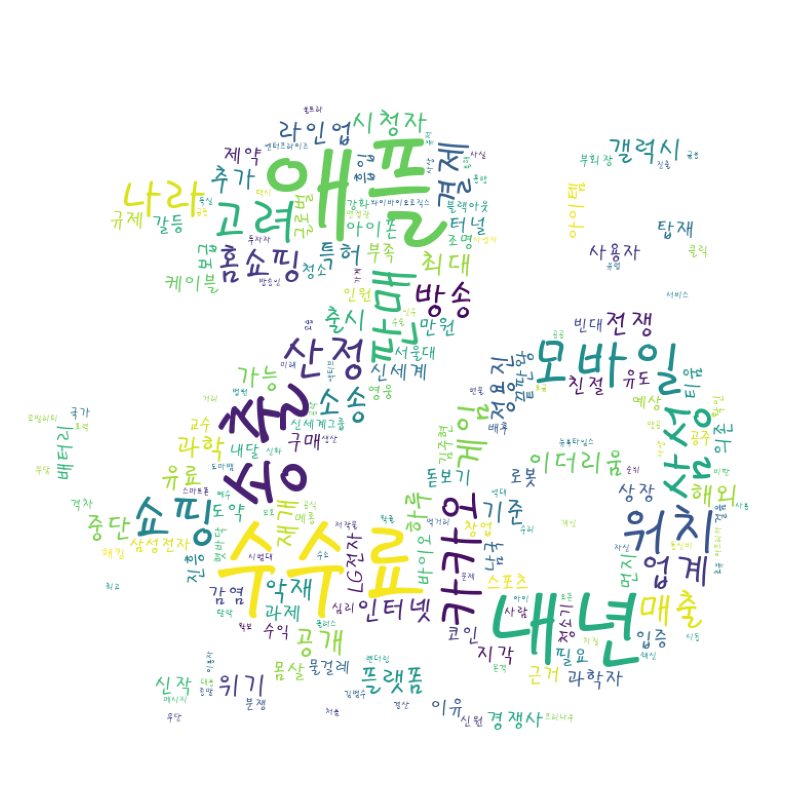

In [2]:
import pandas as pd
import numpy as np
from selenium import webdriver
from bs4 import BeautifulSoup
from kiwipiepy import Kiwi
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import PIL
from collections import Counter

# 데이터베이스 연결
import psycopg2

db_connection = psycopg2.connect(
    host="localhost",  # ip
    dbname="final_project",
    user="postgres",
    password="sesac0916",
    port=5432
)

cursor = db_connection.cursor()

# SELECT 쿼리 실행
cursor.execute("SELECT * FROM final_project.news_information;")
# 결과 가져오기
result = cursor.fetchall()

# 연결 종료
cursor.close()
db_connection.close()

# 데이터프레임으로 불러오기
df_news = pd.DataFrame(result, columns=['id', 'create_dt', 'media_company', 'news_genre', 'news_image_path', 'news_title', 'news_origin', 'news_url', 'news_summary'])

# 'create_dt' 열을 datetime 형식으로 변환
df_news['create_dt'] = pd.to_datetime(df_news['create_dt'])

# 'news_genre'가 'IT/과학'인 데이터만 필터링
df_IT = df_news[df_news['news_genre'] == 'IT/과학']

# Kiwi 형태소 분석기 초기화
kiwi = Kiwi()

# 날짜별로 그룹화하여 형태소 분석 적용
latest_date = df_IT['create_dt'].max().strftime('%m-%d')
df_latest = df_IT[df_IT['create_dt'].dt.strftime('%m-%d') == latest_date]

noun_by_date = df_latest.groupby(df_latest['create_dt'].dt.strftime('%m-%d'))['news_title'] \
    .apply(lambda x: kiwi.tokenize(' '.join(x))) \
    .apply(lambda tokens: [token.form for token in tokens if len(token.form) >= 2 and token.tag in ['NNG', 'NNP', 'NNB', 'NR', 'NP']])

# 날짜별로 형태소 분석된 단어의 개수를 구함
word_counts_by_date = noun_by_date.apply(lambda words: pd.Series(words).value_counts())

# 행/렬 바꾸기
df = word_counts_by_date.T

# 최신 날짜로 데이터 필터링
df_latest = df[[latest_date]].sort_values(by=latest_date, ascending=False)
df_latest = df_latest.reset_index()

# 컬럼명 변경
df_latest.columns = ['word', 'n']

# 결측값 0으로 채우기
df_latest = df_latest.fillna(0)

# 워드클라우드 글씨체
font = "C:\\Windows\\Fonts\\HMFMPYUN.TTF"

dic_word = df_latest.set_index("word").to_dict()['n']

# 워드클라우드 생성 및 출력
plt.figure(figsize=(10, 10))
plt.axis('off')

# 삽입할 이미지 설정
icon = PIL.Image.open('dragon.png')
img = PIL.Image.new('RGB', icon.size, (255, 255, 255))
img.paste(icon, icon)
img = np.array(img)

wc = WordCloud(random_state=1234,         # 난수 고정
               font_path=font,            # 폰트 설정
               width=400,                 # 가로 크기
               height=400,                # 세로 크기
               background_color='white',  # 배경색
               mask=img)                  # mask 설정

# 워드 클라우드 만들기
img_wordcloud = wc.generate_from_frequencies(dic_word)

# 워드 클라우드 출력
plt.imshow(img_wordcloud)
plt.show()

In [3]:
len(df)

251